# Experiment 3: Regression Analysis (Final)

## 1. Aim and Objective
To implement and compare Linear, Ridge, Lasso, and Elastic Net regression models for predicting `Loan Amount Request`. 

## 2. Dataset
- **Target**: `Loan Amount Request (USD)` (Used as proxy for Loan Sanctioned).
- **Features**: Income, Property Price, Credit Score, etc.

## 3. Methodology
1. **Data Cleaning**: Handle '?' in `Property Price` and `Co-Applicant`.
2. **EDA**: Histograms, Box Plots, Pair Plots, Heatmap.
3. **Feature Engineering**: Log-Transforms for skewed data.
4. **Modeling**: Linear, Ridge, Lasso, ElasticNet.


In [22]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [23]:
# HELPER FUNCTIONS
def clean_currency(x):
    if isinstance(x, str):
        x = x.replace('$', '').replace(',', '').replace('?', '').strip()
        if x == '': return np.nan
    return float(x)

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    try:
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(X_test).flatten()
        y_test = np.array(y_test).flatten()
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        train_r2 = r2_score(y_train, model.predict(X_train).flatten())
        
        print(f"\n--- {model_name} ---")
        print(f"Test R2: {r2:.4f} | Train R2: {train_r2:.4f} | RMSE: {rmse:.4f}")
        
        # Residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 4))
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'Residuals - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Residuals')
        plt.show()
        
        return {"Model": model_name, "MAE": mae, "MSE": rmse**2, "RMSE": rmse, "R2 Score": r2, "Train R2": train_r2, "Time (s)": train_time}
    except Exception as e:
        print(f"Error in {model_name}: {e}")
        return None


In [24]:
# DATA LOADING & CLEANING
df = pd.read_csv('test.csv')
print("Shape:", df.shape)

# 1. Explicit Numeric Cleaning
cols_to_clean = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 
                 'Credit Score', 'Property Price', 'Co-Applicant']
for col in cols_to_clean:
    if col in df.columns:
        df[col] = df[col].astype(str).apply(clean_currency)

# 2. Target Identification
target_col = 'Loan Amount Request (USD)'
print(f"Target: {target_col}")

# 3. Drop IDs
df = df.drop(columns=['Customer ID', 'Name', 'Property ID'], errors='ignore')

# 4. Drop highly missing
df = df.dropna(thresh=len(df.columns)*0.7)
df = df.dropna(subset=[target_col])

# 5. Log Transform Target
df = df[df[target_col] > 0]
df['Log_Target'] = np.log1p(df[target_col])

print("Data Cleaned. Shape:", df.shape)


Shape: (20000, 23)
Target: Loan Amount Request (USD)
Data Cleaned. Shape: (20000, 21)


## 4. Exploratory Data Analysis (EDA)
Requested Visualizations: Histogram, Box Plot, Heatmap, Pair Plot.


--- 1. Histogram Distribution ---


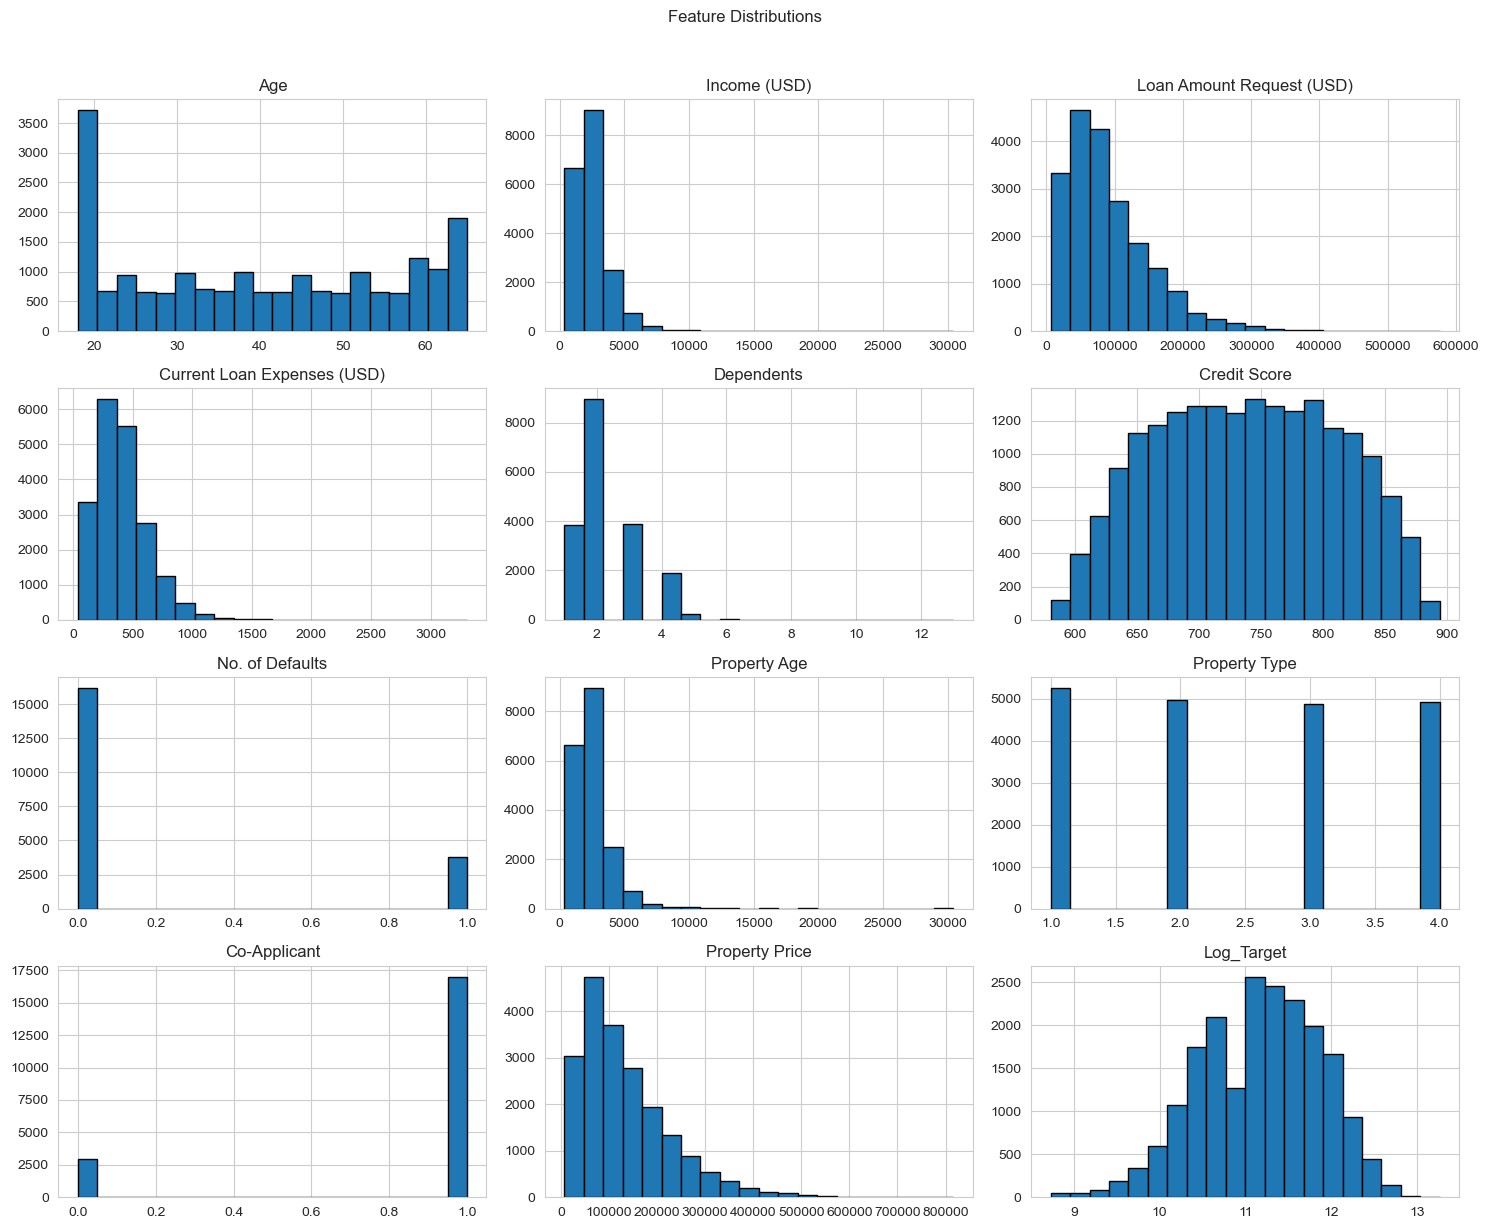


--- 2. Box Plots ---


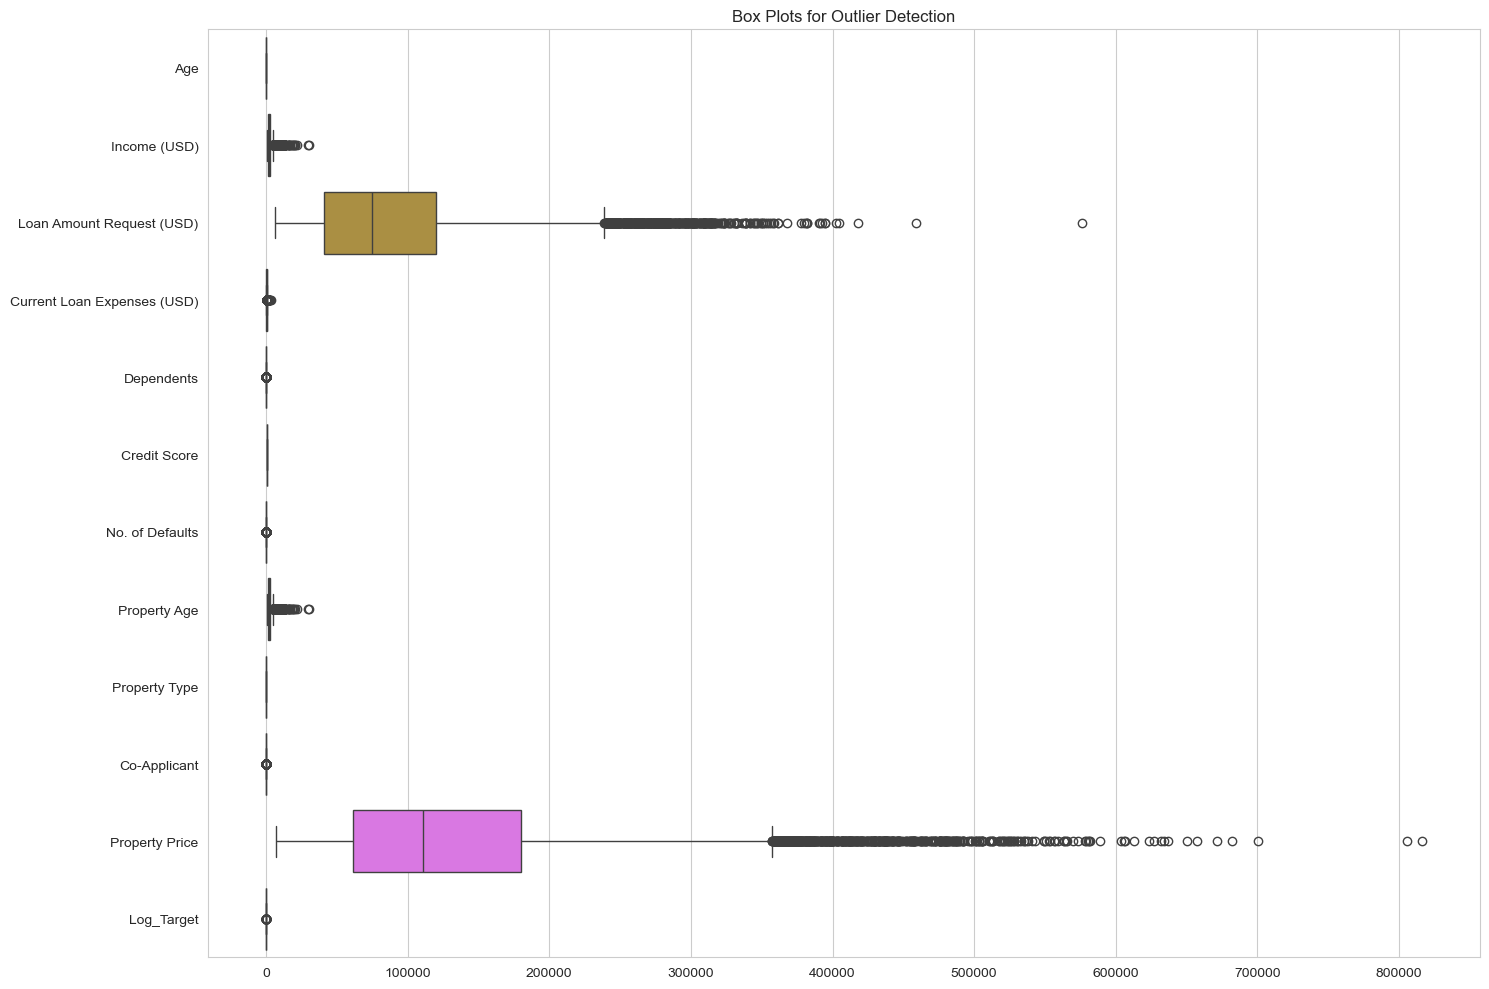


--- 3. Correlation Heatmap ---


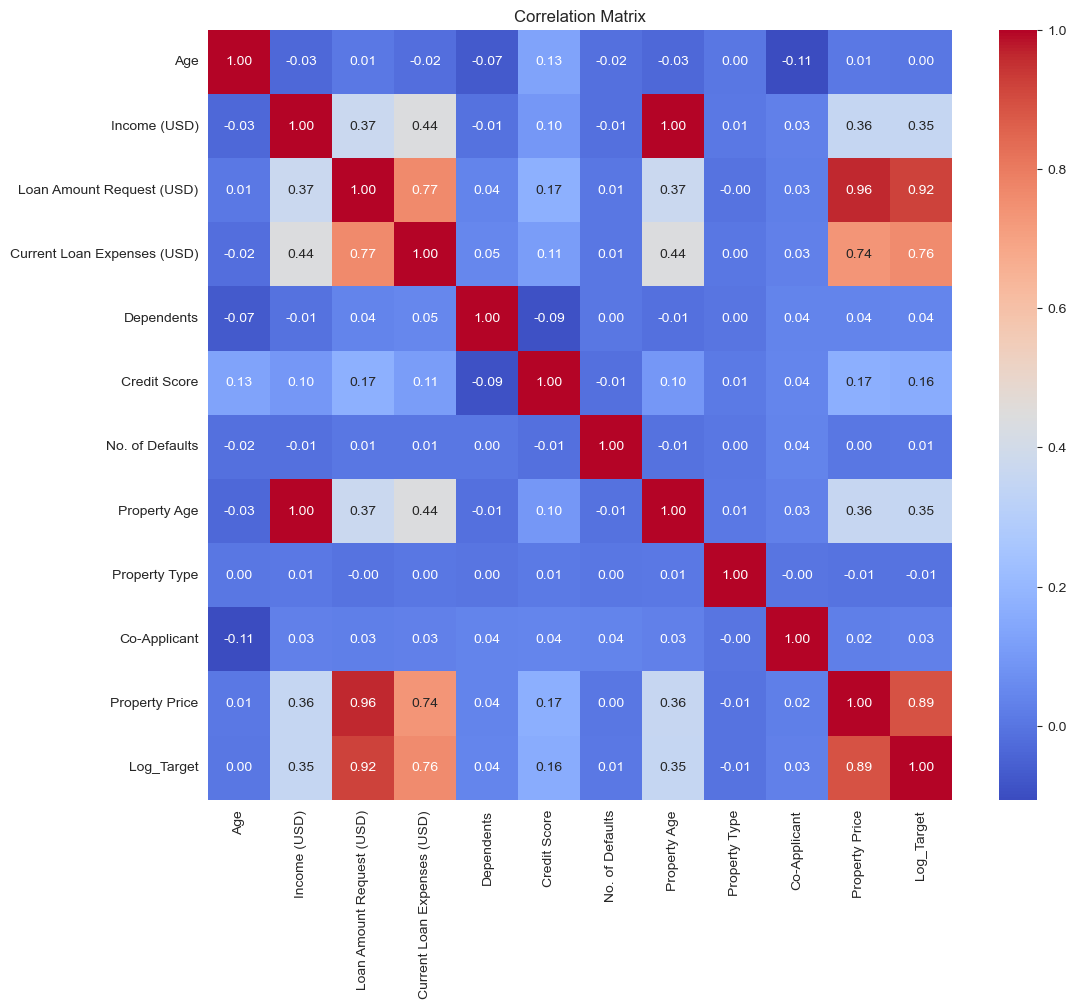


--- 4. Pair Plot ---


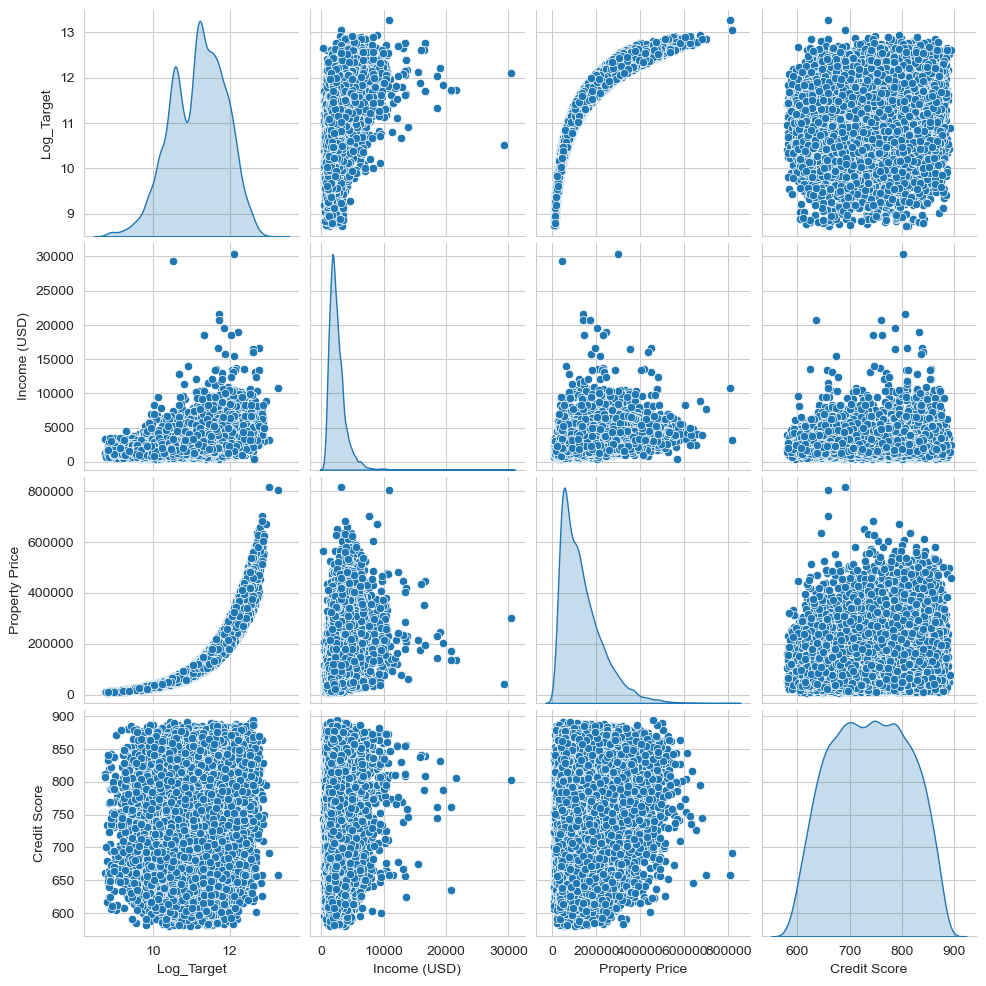

In [25]:
# 1. Histogram Distribution
print("\n--- 1. Histogram Distribution ---")
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols].hist(figsize=(15, 12), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

# 2. Box Plots
print("\n--- 2. Box Plots ---")
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[num_cols], orient='h')
plt.title("Box Plots for Outlier Detection")
plt.tight_layout()
plt.show()

# 3. Correlation Heatmap
print("\n--- 3. Correlation Heatmap ---")
plt.figure(figsize=(12, 10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# 4. Pair Plot (Top correlated features)
print("\n--- 4. Pair Plot ---")
# Select a subset to avoid lag
imp_cols = ['Log_Target', 'Income (USD)', 'Property Price', 'Credit Score']
existing_cols = [c for c in imp_cols if c in df.columns]
sns.pairplot(df[existing_cols], diag_kind='kde')
plt.show()


In [26]:
# ============================
# 5. MODEL PREPARATION
# ============================
X = df.drop(columns=[target_col, 'Log_Target'])
y = df['Log_Target']

num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(include='object').columns

# Pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print(f"Training Data Shape: {X_train.shape}")


Training Data Shape: (16000, 52)



--- Linear Regression ---
Test R2: 0.8160 | Train R2: 0.8104 | RMSE: 0.3065


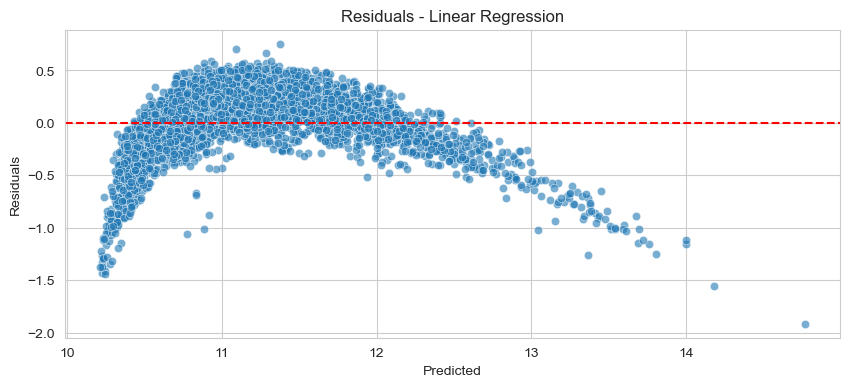


--- Ridge (Grid) ---
Test R2: 0.8160 | Train R2: 0.8103 | RMSE: 0.3064


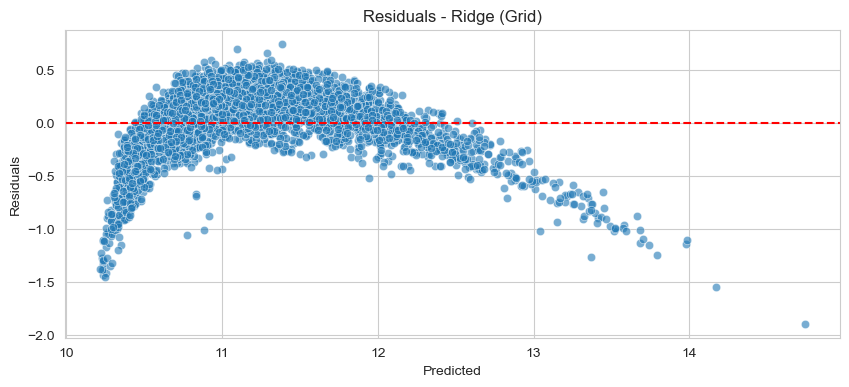


--- Lasso (Grid) ---
Test R2: 0.8163 | Train R2: 0.8100 | RMSE: 0.3062


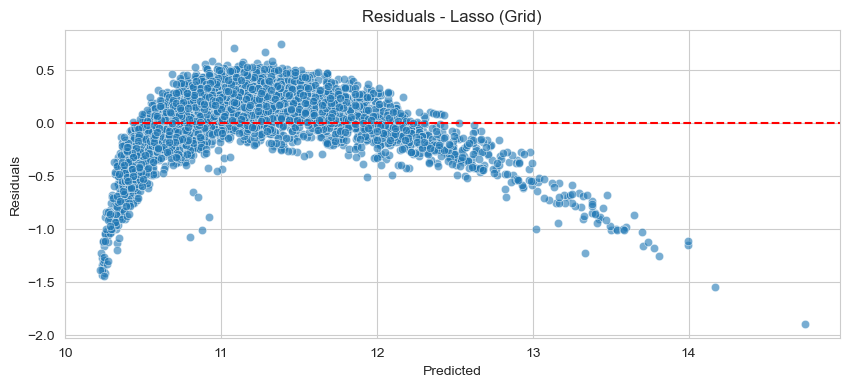


--- ElasticNet (Grid) ---
Test R2: 0.8159 | Train R2: 0.8096 | RMSE: 0.3065


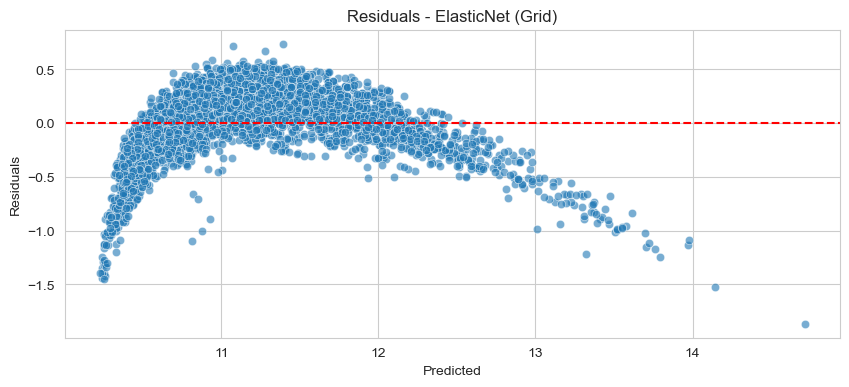

,Model,MAE,MSE,RMSE,R2 Score,Train R2,Time (s)
0,Linear Regression,0.230032,0.093917,0.306459,0.815988,0.810405,0.019246
1,Ridge (Grid),0.230286,0.093896,0.306424,0.816029,0.810332,0.315488
2,Lasso (Grid),0.229954,0.093779,0.306233,0.816259,0.809991,0.428587
3,ElasticNet (Grid),0.230599,0.093949,0.306512,0.815925,0.809644,0.482001


In [27]:
# ============================
# 6. REGRESSION MODELS
# ============================
results = []

# 1. Linear Regression
results.append(evaluate_model(LinearRegression(), X_train, y_train, X_test, y_test, "Linear Regression"))

# 2. Ridge (Best for high dim)
grid_ridge = GridSearchCV(Ridge(), {'alpha': [0.1, 1, 10, 100]}, cv=5, scoring='r2')
results.append(evaluate_model(grid_ridge, X_train, y_train, X_test, y_test, "Ridge (Grid)"))

# 3. Lasso
grid_lasso = GridSearchCV(Lasso(max_iter=5000), {'alpha': [0.001, 0.01, 0.1]}, cv=5, scoring='r2')
results.append(evaluate_model(grid_lasso, X_train, y_train, X_test, y_test, "Lasso (Grid)"))

# 4. Elastic Net
grid_enet = GridSearchCV(ElasticNet(max_iter=5000), {'alpha': [0.01, 0.1], 'l1_ratio': [0.2, 0.8]}, cv=5, scoring='r2')
results.append(evaluate_model(grid_enet, X_train, y_train, X_test, y_test, "ElasticNet (Grid)"))

# Summary
display(pd.DataFrame([r for r in results if r]))
